# Homework 6: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

We have provided training and testing datasets for you to use, that way you're not going to introduce the problem of random sampling when you test your models.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points).

3. Tune your Random Forest model by varying hyperparamters (15 points).

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points).

4. Report the most important feature(s) based on your Random Forest classifier (10 points).

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
test_cv = pd.read_csv('malicious_and_benign_test.csv')
test_cv.head(2)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,B0_2211,78,15,ISO-8859-1,Varnish,9.0,US,DC,18/10/2005 0:00,14/10/2016 0:00,...,6,6,672,8,9,562,672,8,0.0,0
1,B0_854,39,8,utf-8,YouTubeFrontEnd,NaN,US,CA,15/02/2005 0:00,14/01/2017 0:00,...,0,0,0,0,0,0,0,0,0.0,0


In [52]:
cv = pd.read_csv('malicious_and_benign.csv')
cv.head(2)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0


In [53]:
frames = [cv, test_cv]

train_cv = pd.concat(frames).drop_duplicates(keep=False)
train_cv.head(2)
#lowercase
#drop date

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0


In [54]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
categorical = list(train_cv.select_dtypes(include=['object']).columns.values)
for cat in categorical:
    train_cv[cat].fillna('UNK', inplace=True)
    train_cv[cat] = encoder.fit_transform(train_cv[cat])
train_cv.head(2)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,1263,16,7,4,175,263.0,27,85,47,526,...,0,2,700,9,10,1153,832,9,2.0,1
1,633,16,6,3,54,15087.0,27,85,759,526,...,7,4,1230,17,19,1265,1230,17,0.0,0


In [55]:
encoder = preprocessing.LabelEncoder()
categorical = list(test_cv.select_dtypes(include=['object']).columns.values)
for cat in categorical:
    test_cv[cat].fillna('UNK', inplace=True)
    test_cv[cat] = encoder.fit_transform(test_cv[cat])
test_cv.head(2)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,134,78,15,0,49,9.0,25,13,79,36,...,6,6,672,8,9,562,672,8,0.0,0
1,279,39,8,5,51,NaN,25,8,50,31,...,0,0,0,0,0,0,0,0,0.0,0


In [56]:
train_cv.columns[train_cv.isnull().any()].tolist()

['CONTENT_LENGTH', 'DNS_QUERY_TIMES']

In [57]:
test_cv.columns[test_cv.isnull().any()].tolist()

['CONTENT_LENGTH']

In [58]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(train_cv[["CONTENT_LENGTH"]])
train_cv["CONTENT_LENGTH"]=imp.transform(train_cv[["CONTENT_LENGTH"]])
# imp = imp.fit(train_cv)
# X_train_imp = imp.transform(train_cv)
# X_train_imp
#rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')

In [59]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(train_cv[["DNS_QUERY_TIMES"]])
train_cv["DNS_QUERY_TIMES"]=imp.transform(train_cv[["DNS_QUERY_TIMES"]])

In [60]:
train_cv.columns[train_cv.isnull().any()].tolist()

[]

### Build Random Forest classifier to predict the TYPE variable.

In [61]:
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model.fit(train_cv.ix[:,1:20],train_cv.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [63]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(test_cv[["CONTENT_LENGTH"]])
test_cv["CONTENT_LENGTH"]=imp.transform(test_cv[["CONTENT_LENGTH"]])

In [64]:
predicted_labels = rf_model.predict(test_cv.ix[:,1:20])
test_cv['predicted_type'] = predicted_labels
test_cv.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,predicted_type
0,134,78,15,0,49,9.000000,25,13,79,36,...,6,672,8,9,562,672,8,0.0,0,0
1,279,39,8,5,51,9200.947368,25,8,50,31,...,0,0,0,0,0,0,0,0.0,0,0
2,169,43,9,5,49,389.000000,25,8,61,138,...,3,6008,87,107,147266,6312,87,4.0,0,0
3,280,52,10,0,5,5443.000000,4,59,46,6,...,0,0,0,0,0,0,0,0.0,0,0
4,349,100,20,2,5,9200.947368,9,4,67,83,...,1,66,1,3,190,66,1,0.0,1,1


In [66]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_cv.Type, predicted_labels)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 91.04%


### Report the most important feature(s) based on your Random Forest classifier 

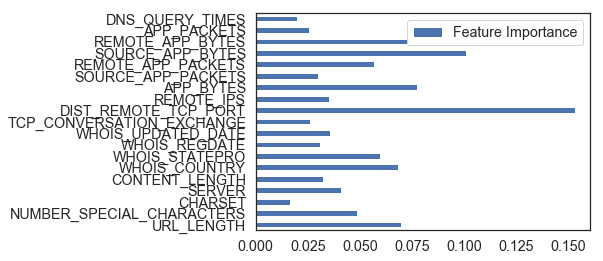

In [86]:
feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=train_cv.columns[1:20]).plot(kind='barh')

### Build Naive Bayes classifier to predict the TYPE variable.

In [177]:
vars_data = list(test_cv)
#vars_to_use = vars_data[1:20]
vars_to_use = ['DIST_REMOTE_TCP_PORT']

In [178]:
gnb_model = sknb.GaussianNB()
gnb_model.fit(train_cv[vars_to_use],train_cv['Type'])

GaussianNB(priors=None)

In [179]:
y_pred = gnb_model.predict(test_cv[vars_to_use])
test_cv['predicted_nb'] = y_pred

In [180]:
accuracy = accuracy_score(test_cv.Type, test_cv['predicted_nb'])
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 53.50%


### Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers

In [80]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
             }

In [81]:
from sklearn.model_selection import GridSearchCV

In [82]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(train_cv.ix[:,1:20],train_cv.Type)
#do a few different numbers for cv = x

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [83]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [84]:
grid_clf.best_params_

{'max_depth': 7, 'n_estimators': 10}

In [85]:
grid_clf.best_score_

0.9410112359550562

In [88]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=8)
grid_clf.fit(train_cv.ix[:,1:20],train_cv.Type)

GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [89]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [90]:
grid_clf.best_params_

{'max_depth': 7, 'n_estimators': 10}

In [91]:
grid_clf.best_score_

0.9389044943820225

In [92]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=12)
grid_clf.fit(train_cv.ix[:,1:20],train_cv.Type)

GridSearchCV(cv=12, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [93]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [94]:
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 20}

In [95]:
grid_clf.best_score_

0.9529494382022472

In [96]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=15)
grid_clf.fit(train_cv.ix[:,1:20],train_cv.Type)

GridSearchCV(cv=15, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [98]:
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 20}

In [99]:
grid_clf.best_score_

0.9536516853932584

### Tune the random forest classifier

In [100]:
param_grid = {
                 'n_estimators': [10, 15, 20, 25, 30],
                 'max_depth': [7, 8, 9, 10],
             }
grid_clf = GridSearchCV(rf_model, param_grid, cv=15)
grid_clf.fit(train_cv.ix[:,1:20],train_cv.Type)

GridSearchCV(cv=15, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [102]:
grid_clf.best_params_

{'max_depth': 10, 'n_estimators': 10}

In [ ]:
#BEST SCORE

In [103]:
grid_clf.best_score_

0.9550561797752809

In [104]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [8, 9, 10, 11],
             }
grid_clf = GridSearchCV(rf_model, param_grid, cv=15)
grid_clf.fit(train_cv.ix[:,1:20],train_cv.Type)

GridSearchCV(cv=15, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [8, 9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [105]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [106]:
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 15}

In [107]:
grid_clf.best_score_

0.9529494382022472

In [108]:
param_grid = {
                 'n_estimators': [15, 20, 25, 30, 35],
                 'max_depth': [6, 7, 8, 9, 10],
             }
grid_clf = GridSearchCV(rf_model, param_grid, cv=15)
grid_clf.fit(train_cv.ix[:,1:20],train_cv.Type)

GridSearchCV(cv=15, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [15, 20, 25, 30, 35], 'max_depth': [6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [109]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [110]:
grid_clf.best_params_

{'max_depth': 10, 'n_estimators': 30}

In [111]:
grid_clf.best_score_

0.9529494382022472

### Experiment with setting the appropriate values for priors in the Naive Bayes model

In [121]:
len_overall = len(train_cv)
len_overall

1424

In [122]:
proportions = train_cv[(train_cv.Type==1)]
len_type1 = len(proportions)
len_type1

166

In [124]:
proportions0 = train_cv[(train_cv.Type==0)]
len_type0 = len(proportions0)
len_type0

1258

In [125]:
benign = len_type0/len_overall
benign

0.8834269662921348

In [126]:
malicious = len_type1/len_overall
malicious

0.11657303370786516

In [127]:
list_benign_malicious = [benign,malicious]

In [181]:
gnb_model = sknb.GaussianNB(priors=list_benign_malicious)
gnb_model.fit(train_cv[vars_to_use],train_cv['Type'])

GaussianNB(priors=[0.8834269662921348, 0.11657303370786516])

In [182]:
y_pred = gnb_model.predict(test_cv[vars_to_use])
test_cv['predicted_nb'] = y_pred

In [183]:
accuracy = accuracy_score(test_cv.Type, test_cv['predicted_nb'])
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 53.50%


In [184]:
gnb_model = sknb.GaussianNB(priors=[0.9,0.1])
gnb_model.fit(train_cv[vars_to_use],train_cv['Type'])

GaussianNB(priors=[0.9, 0.1])

In [185]:
y_pred = gnb_model.predict(test_cv[vars_to_use])
test_cv['predicted_nb'] = y_pred

In [186]:
accuracy = accuracy_score(test_cv.Type, test_cv['predicted_nb'])
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 53.50%


In [187]:
gnb_model = sknb.GaussianNB(priors=[0.95,0.05])
gnb_model.fit(train_cv[vars_to_use],train_cv['Type'])

GaussianNB(priors=[0.95, 0.05])

In [188]:
y_pred = gnb_model.predict(test_cv[vars_to_use])
test_cv['predicted_nb'] = y_pred

In [189]:
accuracy = accuracy_score(test_cv.Type, test_cv['predicted_nb'])
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 85.99%


In [190]:
gnb_model = sknb.GaussianNB(priors=[0.97,0.03])
gnb_model.fit(train_cv[vars_to_use],train_cv['Type'])

GaussianNB(priors=[0.97, 0.03])

In [191]:
y_pred = gnb_model.predict(test_cv[vars_to_use])
test_cv['predicted_nb'] = y_pred

In [192]:
accuracy = accuracy_score(test_cv.Type, test_cv['predicted_nb'])
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 85.99%


In [193]:
gnb_model = sknb.GaussianNB(priors=[0.85,0.15])
gnb_model.fit(train_cv[vars_to_use],train_cv['Type'])

GaussianNB(priors=[0.85, 0.15])

In [194]:
y_pred = gnb_model.predict(test_cv[vars_to_use])
test_cv['predicted_nb'] = y_pred

In [195]:
accuracy = accuracy_score(test_cv.Type, test_cv['predicted_nb'])
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 44.26%


In [196]:
gnb_model = sknb.GaussianNB(priors=[0.99,0.01])
gnb_model.fit(train_cv[vars_to_use],train_cv['Type'])

GaussianNB(priors=[0.99, 0.01])

In [197]:
y_pred = gnb_model.predict(test_cv[vars_to_use])
test_cv['predicted_nb'] = y_pred

In [198]:
accuracy = accuracy_score(test_cv.Type, test_cv['predicted_nb'])
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 85.99%


### Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results. You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! 

Overall, the Random Forest classifier gave better results than the Naive Bayes classifier. The Random Forest classifier, when tuned, would have a best score of .96, while the Naive Bayes classifier, when using priors of 0.95 and 0.05, had an accuracy score of 85.99%. The Random Forest classifier performed the best when all of the columns in the dataset were included, though this is not necessarily what I would expect. Removing things like date, which I thought would have little impact on the classifier, lowered the accuracy score. On the other hand, I was only able to get an initial accuracy score (without changing the priors) above 50% for Naive Bayes including only the DIST_REMOTE_TCP_PORT column, which has information on the number of ports detected and different to TCP. While it makes sense that not all of the information in the dataset is relevant to classifying a website as either benign or malicious, the bar graph showing important features based on the Random Forest classifier, indicated that remote_app_bytes, source_app_bytes, and multiple other variables, were somewhat important, as well. 

In order to improve the results, one thing that would be important would be to add more data. While the dataset is relatively large, with 1,781 total observations, more data is always helpful and could assist in finding stronger correlations between variables, resulting in a more accurate model. 

Another issue in the dataset is missing and categorical variables. In order to deal with categorical values, I used a label encoder to convert them to numerical values. Some of these categorical variables may not be extremely relevant to the type of site, and add unnecessary dimensionality. In order to deal with missing values, I decided to take the mean of a column, rather than drop the row or column. It may have been better to take the median if there were outliers, or research further how many rows had missing data and if there was a pattern before using this method. Outliers in the dataset in general, as well as possible skewness, would be important to address in order to make a more accurate classifier. 

Other possible ways to improve the results would be feature engineering, which creates new features from existing features. This may do a better job of predicting the type of website. Researching the features in the dataset further would also be important, to determine if some features looks important but may not be in reality.